# VAT (MoonDataset)


In [8]:
import pandas as pd
import numpy as np
import re
from IPython.core.display import display
from sklearn.metrics import accuracy_score
import torch
import torch.utils.data
import matplotlib.pyplot as plt
%matplotlib notebook

import collections
import sklearn.datasets

var = torch.autograd.Variable
ftn = torch.FloatTensor
ltn = torch.LongTensor

# Part 1: import data

<IPython.core.display.Javascript object>


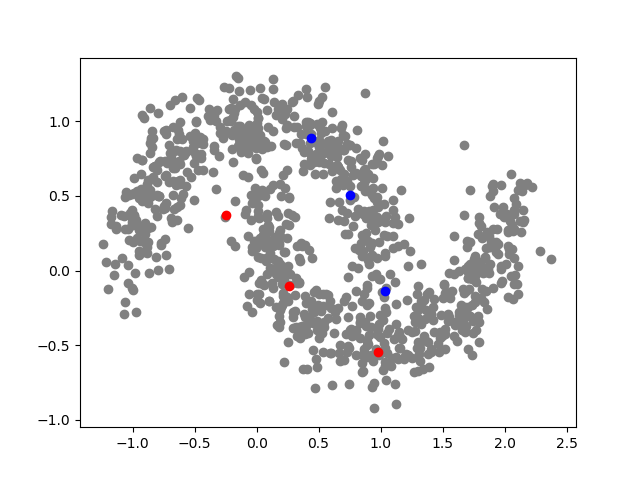

In [50]:
X_all, y_all = sklearn.datasets.make_moons(n_samples=1000, shuffle=False, noise=0.15, random_state=42)
X0_all = X_all[y_all == 0]
X1_all = X_all[y_all == 1]
i_labeled = 400

half_n_labeled = 3


Xu, yu = sklearn.datasets.make_moons(n_samples=1000, shuffle=False, noise=0.15, random_state=42)
X0u = Xu[yu == 0]
X1u = Xu[yu == 1]

Xl, yl = sklearn.datasets.make_moons(n_samples=4*half_n_labeled, shuffle=False, noise=0.15, random_state=43)
X0l = Xl[yl == 0][:half_n_labeled]
X1l = Xl[yl == 1][:half_n_labeled]

fig, ax = plt.subplots()
ax.scatter(X0u[:, 0], X0u[:, 1], c="gray")
ax.scatter(X1u[:, 0], X1u[:, 1], c="gray")
ax.scatter(X0l[:, 0], X0l[:, 1], c="blue")
ax.scatter(X1l[:, 0], X1l[:, 1], c="red")


In [3]:
#データ件数を調べる
print ('Number of label data in X0: {}'.format(X0l.shape[0]))
print ('Number of unlabel data in X0: {}'.format(X0u.shape[0]))

print ('Number of label data in X0: {}'.format(X1l.shape[0]))
print ('Number of unlabel data in X0: {}'.format(X1u.shape[0]))

#total
print ('total Number of label data: {}'.format(Xl.shape[0]))
print ('total Number of unlabel data: {}'.format(Xu.shape[0]))

Number of label data in X0: 3
Number of unlabel data in X0: 500
Number of label data in X0: 3
Number of unlabel data in X0: 500
total Number of label data: 12
total Number of unlabel data: 1000


# Part 2: comparison between VAT, SVM and RF

## VAT

In [10]:
import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(2, 100)
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, 100)
        self.linear4 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [12]:
@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)
    
    
def normalize(d):
    d = d.data.numpy()
    d /= (np.sqrt(np.sum(d ** 2, axis=1)).reshape((-1, 1)) + 1e-16)
    return torch.from_numpy(d)


def _kl_div(logp, logq):
    """D_KL(p || q) = ∑p×(log(p) - log(q))
    """
    logp = torch.nn.functional.log_softmax(logp, dim=1)
    logq = torch.nn.functional.log_softmax(logq, dim=1)
    p = torch.exp(logp)
    return (p*(logp - logq)).sum(dim=1, keepdim=True).mean()


class VATLoss(nn.Module):

    def __init__(self, xi=1e-3, eps=1e-1, ip=2):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 1e-3)
        :param eps: hyperparameter of VAT (default:  1e-1)
        :param ip: iteration times of computing adv noise (default: 2)

        d -> r_adv -> LDS
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def forward(self, model, x):
        with torch.no_grad():
            pred = model(x)

        # prepare random unit tensor
        d = torch.randn(x.shape)
        d = normalize(d)

            # calc adversarial direction
        for _ in range(self.ip):
            d.requires_grad_()
            pred_hat = model(x + self.xi * d)
            adv_distance = _kl_div(pred_hat, pred)
            adv_distance.backward()
            d = normalize(d.grad.data)
            model.zero_grad()
    
            # calc LDS
        r_adv = d * self.eps
        pred_hat = model(x + r_adv)
        lds = _kl_div(pred_hat, pred)

        return lds

In [44]:
#train
i_total_step = 0
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-3)
gamma = 4e1
dataset = torch.utils.data.TensorDataset(ftn(X_all), ltn(y_all))

for i in range(150):#epoch
    data_loader = torch.utils.data.DataLoader(dataset, 121, shuffle=True) #batch size 
    for u, _ in data_loader:
        i_total_step += 1
        vat_loss = VATLoss()
        cross_entropy = nn.CrossEntropyLoss()
        lds = vat_loss(model, torch.tensor(u).float())
        output = model(torch.tensor(Xl).float())
        classification_loss = cross_entropy(output, torch.tensor(yl))
        loss = classification_loss + gamma * lds
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy = accuracy_score(yl,np.argmax(output.data.numpy(),axis=1))
        ce_losses = classification_loss.item()
        vat_losses = gamma*lds.item()
        if i_total_step % 200 == 0:
            print("CrossEntropyLoss %f:" % (ce_losses))
            print("VATLoss %f:" % (vat_losses))
            print("Accuracy %f:" % (accuracy)) 
            print("---------------------------------")

CrossEntropyLoss 0.297870:
VATLoss 0.177687:
Accuracy 0.833333:
---------------------------------
CrossEntropyLoss 0.066398:
VATLoss 0.460021:
Accuracy 1.000000:
---------------------------------
CrossEntropyLoss 0.309549:
VATLoss 0.944291:
Accuracy 0.916667:
---------------------------------
CrossEntropyLoss 0.117578:
VATLoss 0.713550:
Accuracy 0.916667:
---------------------------------
CrossEntropyLoss 0.091461:
VATLoss 0.601797:
Accuracy 0.916667:
---------------------------------
CrossEntropyLoss 0.015123:
VATLoss 1.200090:
Accuracy 1.000000:
---------------------------------


In [49]:
z_pred = torch.nn.functional.softmax(model(var(ftn(X_all), volatile=True)), dim=1).data.numpy()[:, 1]
z_pred = np.where(z_pred > 0.5, 1, 0)
print("the accracy is {0}".format(accuracy_score(yu, z_pred)))

the accracy is 0.989


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


## SVM and RF

In [45]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [46]:
# SVM
svm = SVC()
svm.fit(Xl, yl)
Y_pred = svm.predict(Xu)
print("the accracy is {0}".format(accuracy_score(yu, Y_pred)))

the accracy is 0.855


In [47]:
#RondomForest
rf = RandomForestClassifier()
rf.fit(Xl, yl)
Y_pred = rf.predict(Xu)
print("the accracy is {0}".format(accuracy_score(yu, Y_pred)))

the accracy is 0.845


# Plot

<IPython.core.display.Javascript object>


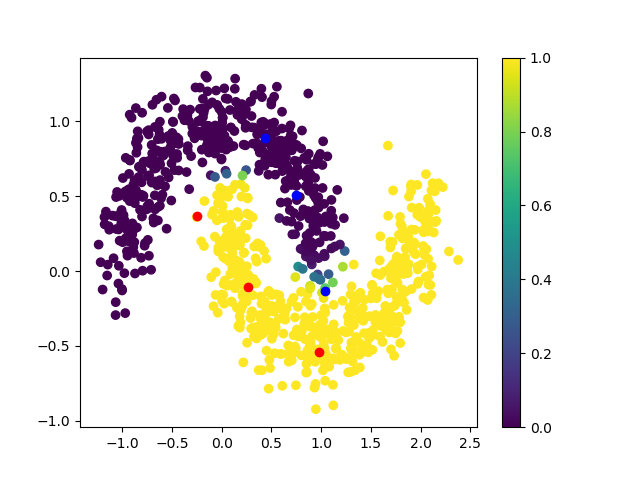

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


<IPython.core.display.Javascript object>


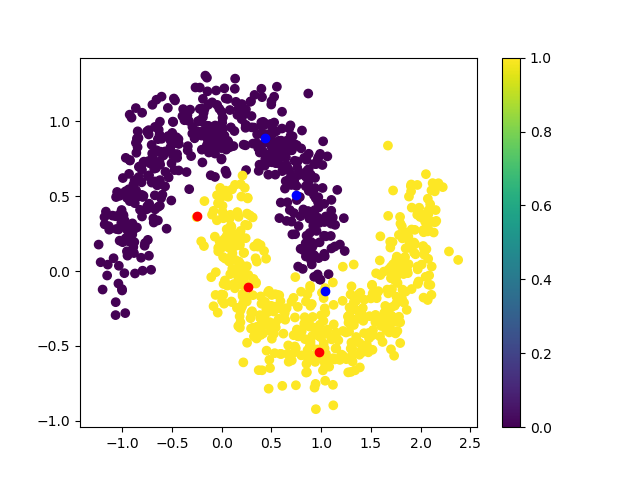

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


In [48]:
fig, ax = plt.subplots()
z_pred = torch.nn.functional.softmax(model(var(ftn(X_all), volatile=True)), dim=1).data.numpy()[:, 1]
h = ax.scatter(X_all[:, 0], X_all[:, 1], c=z_pred, zorder=-1)
ax.scatter(X0l[:, 0], X0l[:, 1], c="blue", zorder=1)
ax.scatter(X1l[:, 0], X1l[:, 1], c="red", zorder=1)
fig.colorbar(h)

fig, ax = plt.subplots()
z_pred = torch.nn.functional.softmax(model(var(ftn(X_all), volatile=True)), dim=1).data.numpy()[:, 1]
z_pred = np.where(z_pred > 0.5, 1, 0)
h = ax.scatter(X_all[:, 0], X_all[:, 1], c=z_pred, zorder=-1)
ax.scatter(X0l[:, 0], X0l[:, 1], c="blue", zorder=1)
ax.scatter(X1l[:, 0], X1l[:, 1], c="red", zorder=1)
fig.colorbar(h)